In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the data into a Pandas dataframe
df = pd.read_parquet(path='./outage_data.parquet', engine='pyarrow')

# Remove duplicate entries in 2019
# Remove all rows with SimStartDate after 2019-01-01 and event_type == 'thunderstorm'
df = df.loc[~((df['SimStartDate'] > '2019-01-01') & (df['event_type'] == 'thunderstorm'))]

In [3]:
# # Splt the data into training and test sets
# # after Nov 1, 2018 is the test set
# df_train = df.loc[df['SimStartDate'] < '2018-11-01']
# # 15 events (15 unique SimStartDate values in the test set)
# df_test = df.loc[df['SimStartDate'] >= '2018-11-01']

In [4]:
# def check_categorical(df, max_unique_values=10):
#     """
#     This function checks each column in the given dataframe to ascertain if it is categorical.
#     It is based on the number of unique values and the data type of the column.
    
#     :param df: Pandas DataFrame containing the data to check
#     :param max_unique_values: The maximum number of unique values to consider a feature as categorical
#     :return: A dictionary with the column name as keys and a boolean indicating if it is categorical as values
#     """
#     categorical = {}
#     for column in df.columns:
#         # Check if the data type is object or if there are few unique values relative to the size of the dataset
#         if df[column].dtype == 'object' or len(df[column].unique()) <= max_unique_values:
#             categorical[column] = True
#         else:
#             # Check for numeric columns that are actually categorical (like IDs or codes)
#             # Here, we'll consider an integer column with a low number of unique values as categorical
#             if df[column].dtype in ['int64', 'int32'] and df[column].nunique() < max_unique_values:
#                 categorical[column] = True
#             else:
#                 categorical[column] = False
#     return categorical

# cate = check_categorical(df)
# # show only the True
# cate = {k: v for k, v in cate.items() if v}
# len(cate)



In [5]:
df.drop(columns = ['point_ewkt'], inplace = True)

# apply ordinal encoding to 'poly_ewkt', 'point_ewkt', 'event_type' columns
non_numerical_columns = ['poly_ewkt', 'event_type']

for column in non_numerical_columns:
    df[column] = df[column].astype('category')
    df[column] = df[column].cat.codes

# Convert datetime columns to separate columns for year, month, day, hour, minute, second
datetime_features = list(df.select_dtypes(include = "datetime64[ns, UTC]").columns)
for i in datetime_features:
    df[i+"_year"] = df[i].dt.year
    df[i+"_month"] = df[i].dt.month
    df[i+"_day"] = df[i].dt.day
    df[i+"_hour"] = df[i].dt.hour

# Use all data after Nov 1, 2018 (15 storms) as test set
test_df = df.loc[df['SimStartDate'] >= '2018-11-01']
train_df = df.loc[df['SimStartDate'] < '2018-11-01']

# Drop columns that are not needed for training
train_df = train_df.drop(datetime_features, axis=1)
test_df = test_df.drop(datetime_features, axis=1)

In [6]:
# # drop the features that whose type is object
# df_train = df_train.select_dtypes(exclude=['object'])
# # drop the features are datetime
# df_train = df_train.select_dtypes(exclude=['datetime64[ns]','datetime64[ms, UTC]'])

In [8]:
lable = train_df['outage_count'].copy()

# Correlation Checking

In [9]:
# Check the correlation between each feature and the target
def check_correction(lable, feature):
    corr = lable.corr(train_df[feature])
    print('The correlation between {} and the target is {:.4f}'.format(feature, corr))
    return corr

In [10]:
# check_correction(lable, df_train.columns[0])

In [13]:
correlation_list = {}
for column in train_df.columns:
    if column != 'outage_count':
        print(column)
        print(train_df[column].dtype)
        correlation_list[column] = check_correction(lable, column)

breaker_counts
int64
The correlation between breaker_counts and the target is 0.2529
fuse_counts
int64
The correlation between fuse_counts and the target is 0.3476
switch_counts
int64
The correlation between switch_counts and the target is 0.2851
transformer_counts
int64
The correlation between transformer_counts and the target is 0.3521
recloser_counts
int64
The correlation between recloser_counts and the target is 0.3400
pole_counts
int64
The correlation between pole_counts and the target is 0.3450
poly_ewkt
int16
The correlation between poly_ewkt and the target is 0.2083
grid_id
int64
The correlation between grid_id and the target is -0.2083
event_type
int8
The correlation between event_type and the target is 0.0203
x
float64
The correlation between x and the target is -0.1548
y
float64
The correlation between y and the target is -0.1191
10 metre wind speed_m s**-1 (max)_lambert_level 10 m_cogt_5
int64
The correlation between 10 metre wind speed_m s**-1 (max)_lambert_level 10 m_cogt

In [23]:

# Select the features with a correlation than 0.8
filtered_dict = {key: value for key, value in correlation_list.items() if value > 0.2}

In [24]:
len(filtered_dict)

12

In [28]:
for i in filtered_dict.keys():
    if '_day' in i:
        print(i)

In [25]:
filtered_dict

{'breaker_counts': 0.2528877612780084,
 'fuse_counts': 0.34758017379125006,
 'switch_counts': 0.2851204931244947,
 'transformer_counts': 0.35208769877463336,
 'recloser_counts': 0.33999282176972484,
 'pole_counts': 0.3450412160794608,
 'poly_ewkt': 0.20830692702316508,
 '(Wind speed (gust)_m s**-1 (max)_lambert_level 10 m-filtered_32-max-20)^2': 0.20269118339763076,
 'length_proxy_30': 0.3352100387951291,
 'line_length_30': 0.3419589122383787,
 'length_proxy_60': 0.32936931187435664,
 'line_length_60': 0.3419589122383787}

{'fuse_counts': 0.34758017379125006,
 'transformer_counts': 0.35208769877463336,
 'recloser_counts': 0.33999282176972484,
 'pole_counts': 0.3450412160794608,
 'length_proxy_30': 0.3352100387951291,
 'line_length_30': 0.3419589122383787,
 'length_proxy_60': 0.32936931187435664,
 'line_length_60': 0.3419589122383787}

In [24]:
df_1_2 = df.iloc[:, 1002:2000]
df_1_2.head()

target = df['outage_count']

The feature with the highest correlation to the target is Absolute vorticity_s**-1 (instant)_lambert_level 50000 Pa-filtered_32-max_sum with a correlation of 0.08


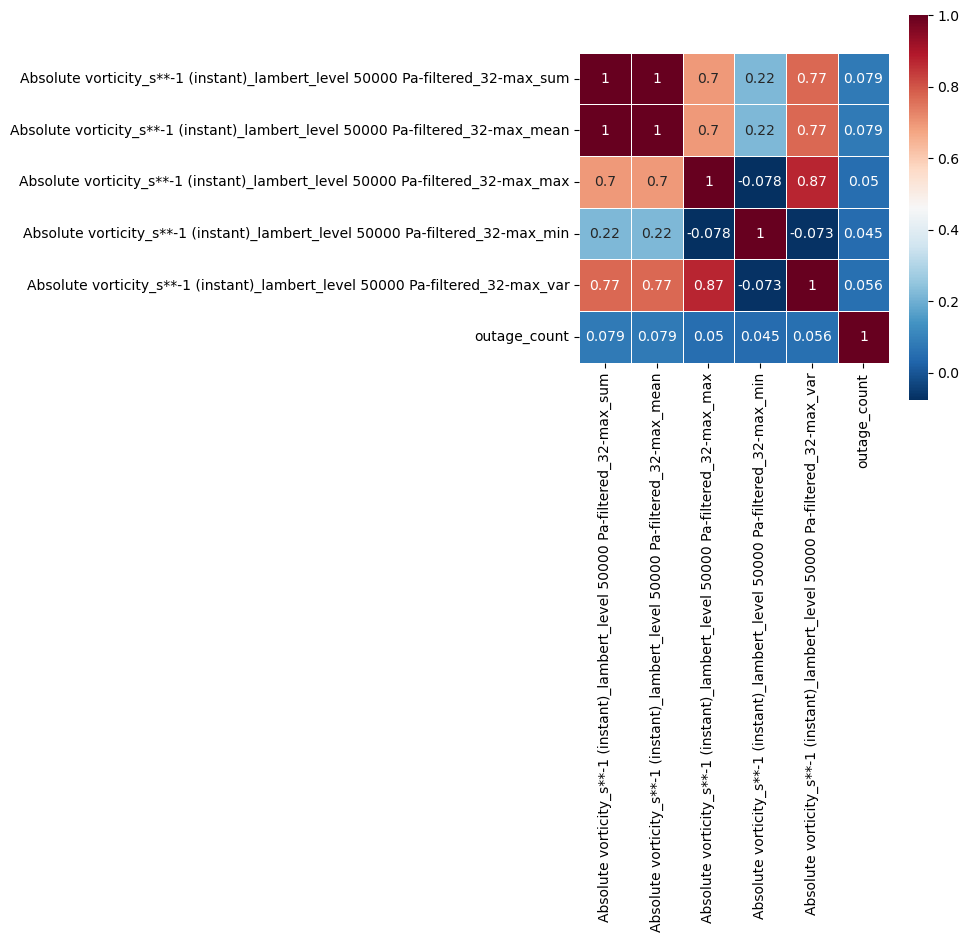

In [34]:
plt.figure(figsize=(5, 5))
cm_df = df_1_2.iloc[:, 0:5]
cm_df['outage_count'] = target
cm = cm_df.corr(method='pearson')
label_column = 'outage_count'
sns.heatmap(cm, annot=True, cmap='RdBu_r', linewidths=0.5, square=True)


# Find the feature with the maximum correlation with the label
max_corr_feature = cm.drop(label_column, axis=0)[label_column].idxmax()
max_corr_value = cm.drop(label_column, axis=0)[label_column].max()


# max_corr_feature = cm[label_column].idxmax()
# max_corr_value = cm[label_column].max()

print('The feature with the highest correlation to the target is {} with a correlation of {:.2f}'.format(max_corr_feature, max_corr_value))

# plt.show()
